In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Bidirectional, LSTM, TimeDistributed, RNN, BatchNormalization
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os

print ('Library loaded')

Library loaded


In [2]:
train_path = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
test_path = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

batch_size = 16
val_batch_size = 8

image_size = 224

## ResNet50

In [3]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=val_batch_size,
                                           shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [4]:
base_model_resnet50 = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_resnet50.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


In [5]:
model_resnet50 = Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(TimeDistributed(Flatten()))
model_resnet50.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Dense(32, activation="relu"))
model_resnet50.add(Dense(32, activation="relu"))
model_resnet50.add(Dense(5, activation="softmax"))
model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 14336)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 256)            14812160  
_________________________________________________________________
dropout (Dropout)            (None, 7, 256)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4

In [6]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

In [7]:
model_resnet50.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_resnet50 = model_resnet50.fit(train_batches, 
                                      validation_data=test_batches, 
                                      epochs=30, 
                                      verbose=1, 
                                      callbacks=[early_stopping, reduce_lr])

Epoch 1/30
380/380 [==============================] - 72s 146ms/step - loss: 0.6013 - acc: 0.8007 - val_loss: 0.2478 - val_acc: 0.9134
Epoch 2/30
380/380 [==============================] - 35s 93ms/step - loss: 0.2008 - acc: 0.9317 - val_loss: 0.1887 - val_acc: 0.9358
Epoch 3/30
380/380 [==============================] - 35s 93ms/step - loss: 0.0842 - acc: 0.9755 - val_loss: 0.1644 - val_acc: 0.9470
Epoch 4/30
380/380 [==============================] - 35s 92ms/step - loss: 0.0398 - acc: 0.9890 - val_loss: 0.1460 - val_acc: 0.9582
Epoch 5/30
380/380 [==============================] - 35s 92ms/step - loss: 0.0258 - acc: 0.9931 - val_loss: 0.1491 - val_acc: 0.9562
Epoch 6/30
380/380 [==============================] - 35s 92ms/step - loss: 0.0180 - acc: 0.9937 - val_loss: 0.1908 - val_acc: 0.9440

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/30
380/380 [==============================] - 36s 96ms/step - loss: 0.0080 - acc: 0.9987 - val_loss: 0.160

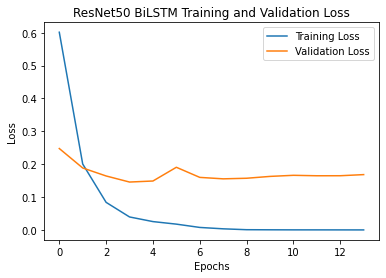

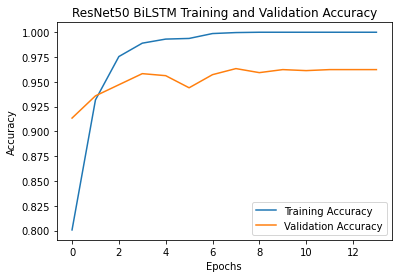

In [8]:
# Plot loss
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_resnet50.history['acc'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
train_score = model_resnet50.evaluate(train_batches, verbose=1)
test_score = model_resnet50.evaluate(test_batches, verbose=1)

123/123 [==============================] - 6s 49ms/step - loss: 0.1460 - acc: 0.9582


In [10]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 8s 46ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.94175   0.94175   0.94175       206
            covid19    0.98544   0.96209   0.97362       211
             normal    0.95370   0.98565   0.96941       209
       tuberculosis    0.99275   0.97857   0.98561       140
    viral_pneumonia    0.93056   0.93056   0.93056       216

           accuracy                        0.95825       982
          macro avg    0.96084   0.95972   0.96019       982
       weighted avg    0.95849   0.95825   0.95828       982



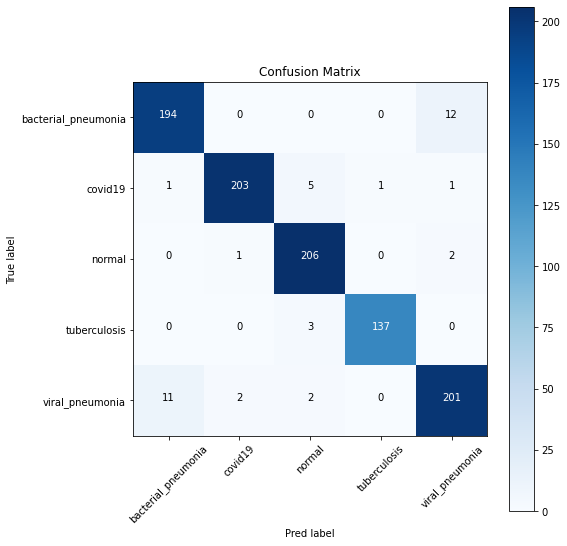

In [11]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_resnet50.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [12]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 30s 79ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    1.00000   0.98525   0.99257      1220
            covid19    0.99919   0.99839   0.99879      1243
             normal    0.99277   1.00000   0.99637      1235
       tuberculosis    1.00000   0.99658   0.99829      1170
    viral_pneumonia    0.98613   0.99752   0.99180      1212

           accuracy                        0.99556      6080
          macro avg    0.99562   0.99555   0.99556      6080
       weighted avg    0.99560   0.99556   0.99556      6080



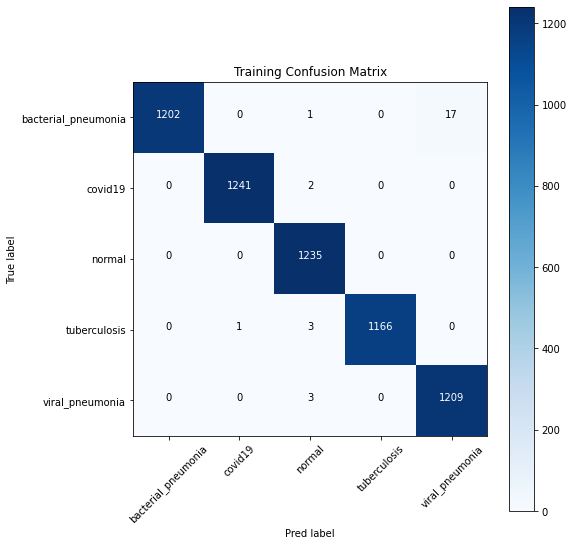

In [13]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_resnet50.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## VGG19

In [14]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [15]:
base_model_vgg19 = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_vgg19.layers:
    layer.trainable = False

80150528/80134624 [==============================] - 0s 0us/step


In [16]:
model_vgg19 = Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(TimeDistributed(Flatten()))
model_vgg19.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Dense(32, activation="relu"))
model_vgg19.add(Dense(32, activation="relu"))
model_vgg19.add(Dense(5, activation="softmax"))

model_vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 3584)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 7, 256)            3802112   
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)               

In [17]:
model_vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_vgg19 = model_vgg19.fit(train_batches, 
                                validation_data=test_batches, 
                                epochs=30, 
                                verbose=1, 
                                callbacks=[early_stopping, 
                                           reduce_lr])

Epoch 1/30
380/380 [==============================] - 55s 121ms/step - loss: 1.5214 - acc: 0.3316 - val_loss: 1.3733 - val_acc: 0.5081
Epoch 2/30
380/380 [==============================] - 41s 108ms/step - loss: 1.3316 - acc: 0.5469 - val_loss: 1.1687 - val_acc: 0.6344
Epoch 3/30
380/380 [==============================] - 41s 107ms/step - loss: 1.1396 - acc: 0.6913 - val_loss: 0.9986 - val_acc: 0.7230
Epoch 4/30
380/380 [==============================] - 41s 108ms/step - loss: 0.9751 - acc: 0.7567 - val_loss: 0.8631 - val_acc: 0.7607
Epoch 5/30
380/380 [==============================] - 41s 108ms/step - loss: 0.8307 - acc: 0.8118 - val_loss: 0.7498 - val_acc: 0.7831
Epoch 6/30
380/380 [==============================] - 41s 107ms/step - loss: 0.7010 - acc: 0.8433 - val_loss: 0.6591 - val_acc: 0.7994
Epoch 7/30
380/380 [==============================] - 41s 108ms/step - loss: 0.5871 - acc: 0.8732 - val_loss: 0.5847 - val_acc: 0.8065
Epoch 8/30
380/380 [==============================] - 4

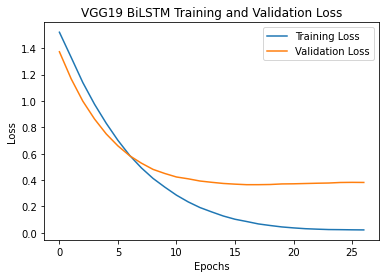

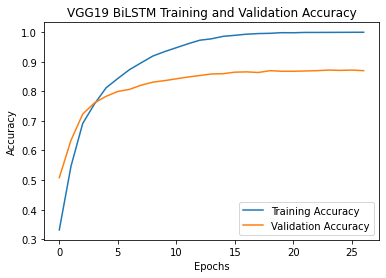

In [18]:
# Plot loss
plt.plot(history_vgg19.history['loss'], label='Training Loss')
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss')
plt.title('VGG19 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_vgg19.history['acc'], label='Training Accuracy')
plt.plot(history_vgg19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG19 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
train_score = model_vgg19.evaluate(train_batches, verbose=1)
test_score = model_vgg19.evaluate(test_batches, verbose=1)

123/123 [==============================] - 8s 65ms/step - loss: 0.3649 - acc: 0.8656


In [20]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 9s 63ms/step

Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.79621   0.81553   0.80576       206
            covid19    0.89908   0.92891   0.91375       211
             normal    0.92746   0.85646   0.89055       209
       tuberculosis    0.94326   0.95000   0.94662       140
    viral_pneumonia    0.79452   0.80556   0.80000       216

           accuracy                        0.86558       982
          macro avg    0.87211   0.87129   0.87133       982
       weighted avg    0.86684   0.86558   0.86582       982



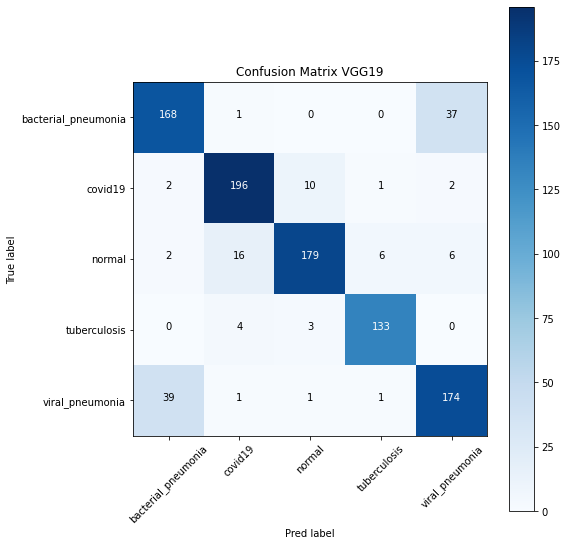

In [21]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_vgg19.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report VGG19:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix VGG19")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [22]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 35s 93ms/step

Training Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.99755   0.99918   0.99836      1220
            covid19    1.00000   0.99759   0.99879      1243
             normal    0.99838   0.99757   0.99797      1235
       tuberculosis    0.99915   0.99915   0.99915      1170
    viral_pneumonia    0.99588   0.99752   0.99670      1212

           accuracy                        0.99819      6080
          macro avg    0.99819   0.99820   0.99820      6080
       weighted avg    0.99819   0.99819   0.99819      6080



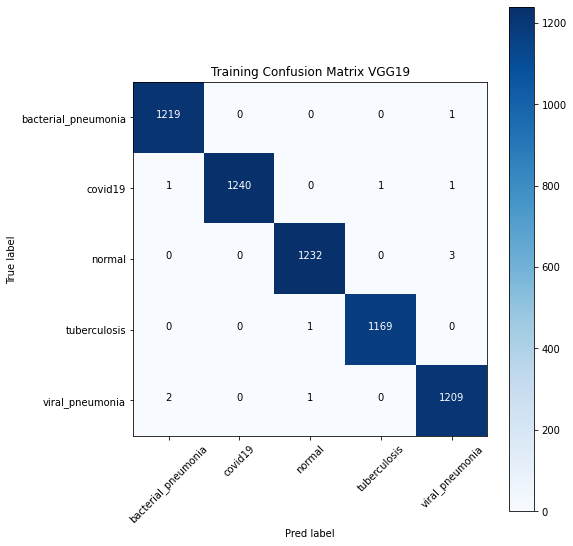

In [23]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_vgg19.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report VGG19:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix VGG19")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## InceptionV3

In [24]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [25]:
base_model_inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_inceptionv3.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


In [26]:
model_inceptionv3 = Sequential()
model_inceptionv3.add(base_model_inceptionv3)
model_inceptionv3.add(TimeDistributed(Flatten()))
model_inceptionv3.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Dense(32, activation="relu"))
model_inceptionv3.add(Dense(32, activation="relu"))
model_inceptionv3.add(Dense(5, activation="softmax"))

model_inceptionv3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 10240)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 5, 256)            10617856  
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)               

In [27]:
model_inceptionv3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_inceptionv3 = model_inceptionv3.fit(train_batches, 
                                            validation_data=test_batches, 
                                            epochs=30, 
                                            verbose=1, 
                                            callbacks=[early_stopping, 
                                                       reduce_lr])

Epoch 1/30
380/380 [==============================] - 44s 92ms/step - loss: 1.4926 - acc: 0.3164 - val_loss: 1.3709 - val_acc: 0.3961
Epoch 2/30
380/380 [==============================] - 31s 81ms/step - loss: 1.3524 - acc: 0.3956 - val_loss: 1.2648 - val_acc: 0.4562
Epoch 3/30
380/380 [==============================] - 32s 83ms/step - loss: 1.2703 - acc: 0.4470 - val_loss: 1.1932 - val_acc: 0.5377
Epoch 4/30
380/380 [==============================] - 31s 81ms/step - loss: 1.2153 - acc: 0.4859 - val_loss: 1.1431 - val_acc: 0.5784
Epoch 5/30
380/380 [==============================] - 31s 83ms/step - loss: 1.1719 - acc: 0.5189 - val_loss: 1.1037 - val_acc: 0.5998
Epoch 6/30
380/380 [==============================] - 31s 81ms/step - loss: 1.1325 - acc: 0.5581 - val_loss: 1.0703 - val_acc: 0.6232
Epoch 7/30
380/380 [==============================] - 31s 82ms/step - loss: 1.1003 - acc: 0.5822 - val_loss: 1.0422 - val_acc: 0.6395
Epoch 8/30
380/380 [==============================] - 31s 81ms

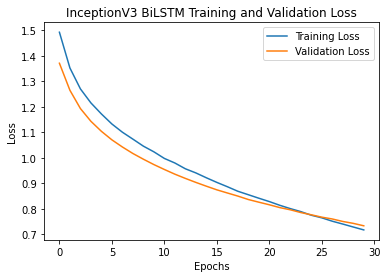

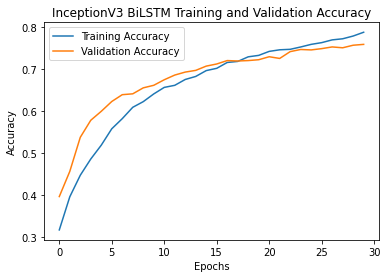

In [28]:
# Plot loss
plt.plot(history_inceptionv3.history['loss'], label='Training Loss')
plt.plot(history_inceptionv3.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_inceptionv3.history['acc'], label='Training Accuracy')
plt.plot(history_inceptionv3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
train_score = model_inceptionv3.evaluate(train_batches, verbose=1)
test_score = model_inceptionv3.evaluate(test_batches, verbose=1)

123/123 [==============================] - 5s 43ms/step - loss: 0.7330 - acc: 0.7597


In [30]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 7s 42ms/step

Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.76378   0.47087   0.58258       206
            covid19    0.79911   0.84834   0.82299       211
             normal    0.82126   0.81340   0.81731       209
       tuberculosis    0.92126   0.83571   0.87640       140
    viral_pneumonia    0.61616   0.84722   0.71345       216

           accuracy                        0.75967       982
          macro avg    0.78431   0.76311   0.76255       982
       weighted avg    0.77358   0.75967   0.75487       982



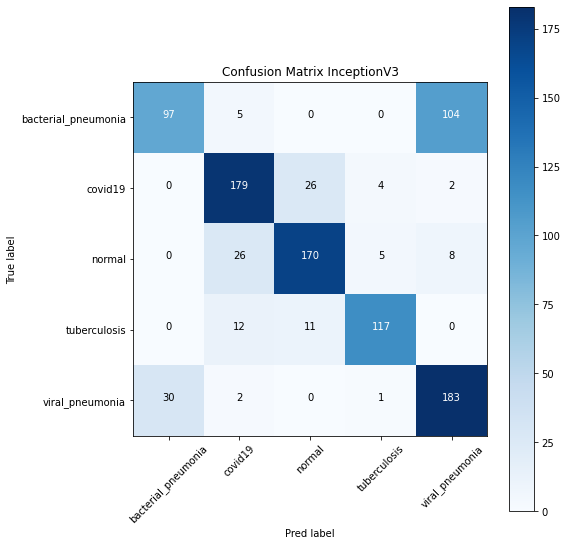

In [31]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_inceptionv3.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report InceptionV3 :\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix InceptionV3")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [32]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 25s 67ms/step

Training Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.79412   0.46475   0.58635      1220
            covid19    0.88164   0.88093   0.88129      1243
             normal    0.87459   0.86397   0.86925      1235
       tuberculosis    0.92000   0.94359   0.93165      1170
    viral_pneumonia    0.61209   0.86056   0.71536      1212

           accuracy                        0.80197      6080
          macro avg    0.81649   0.80276   0.79678      6080
       weighted avg    0.81630   0.80197   0.79628      6080



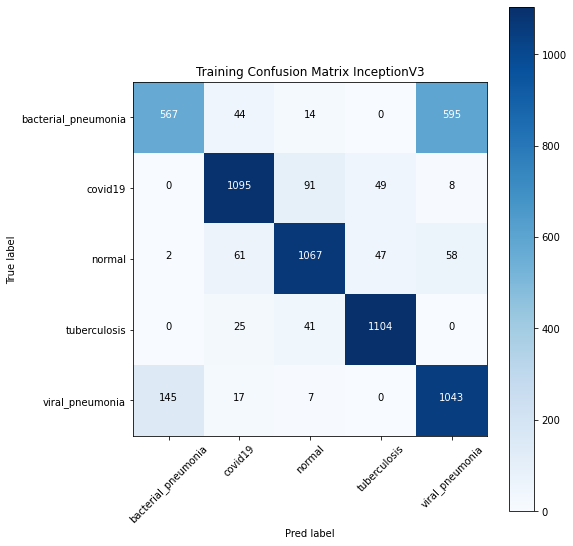

In [33]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_inceptionv3.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report InceptionV3 :\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix InceptionV3")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()